<a href="https://colab.research.google.com/github/bman222112/ECE551/blob/main/Module%206.1_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="font-size:28px;font-weight:bold;">Module 6.1 - Convolutional Neural Networks</p>
<p>This module introduces the concept of Convolutional Neural Networks, and how to handle processing the feature extracted audio dataset.</p>
<p>The first thing, below, is a class, <span style="color:green;font-weight:bold;">class</span> <span style="color:blue;font-weight:bold">CCDataset</span>, that defines how one of the previously feature extracted datasets will be read in. This class loads the Numpy file and labels, along with the ordered indicies from which to return the data. This allows us to create separate datasets for both the training and the test from the same parent data.</p>
<p>Please note: No formal hyperparameter validation has been done for this example. All of the hyperparameter values were chosen using a rough manual search. An expanded effort to include a more formal process would be beneficial to improve overall performance</p>

In [1]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash

Detected operating system as Ubuntu/jammy.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.4.14
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.


In [2]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Need to get 8,917 kB of archives.
After this operation, 8,712 kB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu jammy/main amd64 git-lfs amd64 3.7.0 [8,917 kB]
Fetched 8,917 kB in 1s (9,225 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
(Reading database ... 126288 files and directories currently installed.)
Preparing to unpack .../gi

In [3]:
%cd /content
!git clone https://www.github.com/bman222112/ECE551.git
%cd /content/ECE551

/content
Cloning into 'ECE551'...
remote: Enumerating objects: 1009, done.
remote: Total 1009 (delta 0), reused 0 (delta 0), pack-reused 1009 (from 2)
Receiving objects: 100% (1009/1009), 747.11 MiB | 15.16 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Updating files: 100% (953/953), done.
Filtering content: 100% (2/2), 252.93 MiB | 24.74 MiB/s, done.
/content/ECE551


In [23]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [24]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import torch

class CCDataset(Dataset):
    def __init__(self, labels, datafile, inds, transform=None, target_transform=None):
        self.labels = np.load(labels).astype("int");
        self.data = np.load(datafile).astype(np.float32);
        self.transform = transform
        self.target_transform = target_transform
        self.indices = inds;

    def __len__(self):
        return len(self.indices);

    def __getitem__(self, idx):
        dat = self.data[self.indices[idx]][:][:];
        if self.transform:
            dat = self.transform(dat);
        if self.target_transform:
            dat = self.target_transform(dat);
        return dat, self.labels[self.indices[idx]];

Because we don't know how many total samples there are yet, to generate the random indicies, we can read in the labels definition and use it's length to generate the ranges

In [25]:
labels = np.load("Labels_aug.npy");

In [26]:
import random
random.seed(10)
trainInds = random.sample(range(len(labels)),round(len(labels)*0.9));
testInds = [item for item in random.sample(range(len(labels)),round(len(labels))) if item not in trainInds];


With the ranges for training and test specified, we can read in the data using our <span style="color:blue;font-weight:bold;">CCDataset</span> class. Notice we are only reading in the MFCC and LFCC data. Because the LPC dataset is not 2-Dimensional, the same Neural Network model cannot be used with LPC data. Module 7 will provide the same basic model modified for 2D data.

In [27]:
from torchvision.transforms import ToTensor
MFCC_train_data = CCDataset("Labels_aug.npy","3D_MFCC_aug.npy",trainInds, transform=ToTensor());
MFCC_test_data = CCDataset("Labels_aug.npy","3D_MFCC_aug.npy",testInds, transform=ToTensor());
LFCC_train_data = CCDataset("Labels_aug.npy","3D_LFCC_aug.npy",trainInds, transform=ToTensor());
LFCC_test_data = CCDataset("Labels_aug.npy","3D_LFCC_aug.npy",testInds, transform=ToTensor());

Now that we have read in our data, we need a DataLoader object to use with training. Based on empirical testing, a batch size of 3 appeared to work the best for this dataset. Increasing the batch size will dramatically reduce model training times, but may negatively impact performance.

In [28]:
from torch.utils.data import DataLoader
batch_size = 3

# Create data loaders.
MFCC_train_dataloader = DataLoader(MFCC_train_data, batch_size=batch_size)
MFCC_test_dataloader = DataLoader(MFCC_test_data, batch_size=batch_size)
LFCC_train_dataloader = DataLoader(LFCC_train_data, batch_size=batch_size)
LFCC_test_dataloader = DataLoader(LFCC_test_data, batch_size=batch_size)

for X, y in MFCC_train_dataloader:
    print(f"Shape of X [N, C, M, T]: {X.shape} {X.dtype}")
    print("N = batch size. This is the number of images to process at a time.")
    print("C = number of channels. Only 1 for Cepstrum Coefficient Data")
    print("M = number of Cepstrum Coefficients")
    print("T = time in blocks")
    print(" ")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print("y is of size N, the ground truth labels")
    print(y)
    break

train_size = len(MFCC_train_dataloader.dataset)
test_size  = len(MFCC_test_dataloader.dataset)
train_pct  = 100*train_size/(train_size+test_size)
test_pct   = 100*test_size/(train_size+test_size)
print(f"Percentage of training dataset = {train_pct:.2f} percent with {train_size} samples.")
print(f"Percentage of test dataset     = {test_pct:.2f} percent with {test_size} samples.")

Shape of X [N, C, M, T]: torch.Size([3, 1, 13, 181]) torch.float32
N = batch size. This is the number of images to process at a time.
C = number of channels. Only 1 for Cepstrum Coefficient Data
M = number of Cepstrum Coefficients
T = time in blocks
 
Shape of y: torch.Size([3]) torch.int64
y is of size N, the ground truth labels
tensor([10,  1,  8])
Percentage of training dataset = 90.01 percent with 2479 samples.
Percentage of test dataset     = 9.99 percent with 275 samples.


As can be seen, the resulting output for the MFCC_train_dataloader shows an output for training of <b>[batch, 1, MFCCs, Time]</b>, matching our MFCC data and the batch size.</br></br>
Next, we'll define our class names, along with a quick test to see what the first item out of our dataset is, and verify it is labeled correctly

In [29]:
classes = ["Pump 1 Start", "Pump 1 Run", "Pump 1 Stop", "Pump 2 Start", "Pump 2 Run", "Pump 2 Stop", "Pump 3 Start", "Pump 3 Run", "Pump 3 Stop", "Pump 4 Start", "Pump 4 Run", "Pump 4 Stop"];

In [30]:
print(f"Expected: \t{classes[labels[trainInds[1]].astype('int')]}\nFrom Dataset: \t{classes[MFCC_train_data.__getitem__(1)[1]]}");

Expected: 	Pump 1 Run
From Dataset: 	Pump 1 Run


<p>Next, let's plot the data from the last batch determined from the dataloader above. This will show what the data looks like, and verify the labels for the samples in the batch</p>

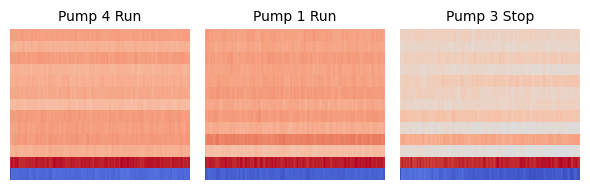

In [31]:
import matplotlib.pyplot as plt
import math
def show_images(batch_tensor, n=3, titles=None):
    """
    Display all Cepstrum Coefficients from a batch [B, 1, H, W]

    Parameters:
    - batch_tensor: torch.Tensor of shape [B, 1, H, W]
    - n: number of plots to show
    - titles: list of titles or labels for each image (length n)
    """
    n = min(n, batch_tensor.size(0))
    if titles is None:
        titles = [f"Image {i}" for i in range(n)]
    else:
        assert len(titles) >= n, "Not enough titles for the number of images."

    # Determine grid size
    cols = n
    rows = 1;

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(n):
        img = batch_tensor[i, 0].cpu().numpy()
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='coolwarm', aspect="auto", interpolation="none")
        plt.gca().invert_yaxis();
        plt.title(classes[y[i]], fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(batch_tensor=X, n=3, titles=y)

<p>Next, we are ready for our CNN Model. This model is built up of:
    <ul>
        <li>2 convolutional layers</li>
        <li>A 2x2 pooling layer applied multiple times</li>
        <li>A dropout layer with 25% probability applied multiple times</li>
        <li>A linear stack comprised of
        <ul style="list-style-type:square;">
            <li>A linear layer outputting 512 elements</li>
            <li>A second linear layer with the same number of inputs and outputs</li>
        </ul>
    </ul>  

In [32]:
from torch import nn
import torch.nn.functional as F
class Test_CNN(nn.Module):
    def __init__(self, num_of_rows = 13, num_of_cols = 181,
                 n_filters1=4, n_filters2=8, out_categories=12):
        super().__init__()

        self.conv1 = nn.Conv2d(
                in_channels=1,            # 1 for grayscale
                out_channels=n_filters1,   # Number of filters
                kernel_size=3,            # 3x3 convolution
                stride=1,
                padding=1          # Keep output size same as input
                )
        self.pool = nn.MaxPool2d(2, 2)  # halves size

        self.conv2 = nn.Conv2d(
                in_channels=n_filters1,    # NOTE: Use n_filters1 from conv1
                out_channels=n_filters2,   # New number of filters
                kernel_size=3,            # 3x3 convolution
                stride=1,
                padding=1          # Keep output size same as input
                )

        self.drop = nn.Dropout2d(p=0.25); # Drops samples to 0 with a 25% probability

        # out_categories should match the number of output categories.
        # Match the dimensions to the input.
        # Divide by 2 for each maxpooling (carefull for non-even numbers ...)
        num_of_points = math.floor(num_of_rows/(2*2)) * math.floor(num_of_cols/(2*2))

        # Linear layer stack
        # Accepts the outputs from previous layer, outputs 512
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_of_points*n_filters2, 512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )

        # Final layer collects the pixels from all of the inputs:
        self.fc1 = nn.Linear(512, out_categories)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [batch, 4, rows/2, cols/2]
        x = self.drop(x);                     # -> Apply dropout
        x = self.pool(F.relu(self.conv2(x)))  # -> [batch, 8, rows/4, cols/4]
        x = self.drop(x);                     # -> Apply dropout a second time
        x = x.view(x.size(0), -1)             # -> flatten to [batch, 8*(rows/4)*(cols/4)]
        x = self.linear_relu_stack(x);        # -> Pass through linear stack
        logits = F.relu(self.fc1(x))          # -> Determine logits
        return logits # Note: SoftMax is applied to logits by cross-entropy loss function.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
torch.cuda.empty_cache()
model = Test_CNN(n_filters1=4, n_filters2=8).to(device)

<p>Looking at the full model, we can print the model and the full list of parameters for each layer. Shown below, the number of parameters in this CNN model are substantially greater than those from the KNN or RF classifiers used in previous modules.</p>

In [33]:
def parameter_report(model):
    print(f"{'Layer':<40} {'# Params':>12} {'Trainable':>10}")
    print("-" * 65)
    total, trainable = 0, 0
    for name, param in model.named_parameters():
        num_params = param.numel()
        is_trainable = param.requires_grad
        print(f"{name:<40} {num_params:>12,} {str(is_trainable):>10}")
        total += num_params
        if is_trainable:
            trainable += num_params
    print("-" * 65)
    print(f"{'Total':<40} {total:>12,} {'':>10}")
    print(f"{'Trainable':<40} {trainable:>12,}")


print(model)
print(" ")

parameter_report(model)

Test_CNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop): Dropout2d(p=0.25, inplace=False)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1080, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (fc1): Linear(in_features=512, out_features=12, bias=True)
)
 
Layer                                        # Params  Trainable
-----------------------------------------------------------------
conv1.weight                                       36       True
conv1.bias                                          4       True
conv2.weight                                      288       True
conv2.bias                                          8       True
linear_relu_stack.0.weight                    552,960       True
linear_relu

<p>To train the model, we need to specify a loss function and an optimizer. Based on our output of raw, un-normalized logits in the model, we are limited to CrossEntropyLoss or BCEWithLogitsLoss from the PyTorch library. Here we will select CrossEntropy, and use Stochastic Gradient Decent as the optimizer.</p>

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

<p>The training function, defined below, runs through a given number of epochs, or until the model demonstrates small enough changes to the average training loss. For each epoch, the function runs through all of the batches within the dataloader and tests the model accuracy. After each epoch, a learning rate scheduler is update, with the goal of tailoring the learning rate to the current optimization state. Both an Exponential learning rate and a MultiStep learning rate scheduler are used to try and improve the speed at which the average loss converges.</p>

<p>In addition, a progress bar is printed to monitor training progress. If interested in the progression of the training, there is a commented print statement that will produce the average loss rate for each epoch</p>

In [35]:
from torch.optim.lr_scheduler import LRScheduler
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import ExponentialLR
import gc

def train(dataloader, model, loss_fn, optimizer, epochs):
    size = len(dataloader.dataset)
    model.train() # Put the model in training mode.
    scheduler1 = ExponentialLR(optimizer, gamma=0.9)
    scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    print(f"  0%[{20*' '}]\r",end="");
    loss_last = 0;
    twice = False;
    for ep in range(epochs):
        test_loss, num = 0, 0
        for batch, (X, y) in enumerate(dataloader):
            # Place the model and predictions on the same device.
            X, y = X.to(device), y.to(device)
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item();
            num+=1;

            # Backpropagation
            # This step updates the parameter values inside your network.
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            del X, y, pred;
            torch.cuda.empty_cache()
        if (loss_last - (test_loss/num)  < 0.005 and loss_last - (test_loss/num) > 0):
            if twice:
                break;
            else:
                twice = True;
        else:
            loss_last = test_loss/num;

        #print(f"loss: {test_loss/num:>7f}")
        print(f"{100*(ep/epochs):3.0f}%[{(int(20 * ep/epochs)*'■')}{(20-int(20 * ep/epochs))*' '}]\r",end="");   # Print a progress bar. A number of blocks are printed based on the percentage through the count of epochs
        # Step the learning rate schedulers based on the current status
        scheduler1.step();
        scheduler2.step();
    print(f"100%[{20*'■'}]\r");        # We need to make sure to jump the progress bar to 100% at the end, especially if we broke early due to small enough change in loss

<p>To test the model, we have the following function, which will calculate the accuracy of the model on another (the test) dataloader</p>

In [36]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Put the model in testing mode.
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss;

<p>Finally it is time to train the model. The following two functions will run through the training, and then print the accuracy and average loss for the test dataset. Be aware, even when run on a CUDA accelerated GPU for processing, this step can be slow. The small batch size forces many steps to push the data to the GPU, and takes time to process.</p>

<p>It has been observed through testing that when using CUDA, occasionally the model training will fail and loss will remain in excess of 2. If this happens, generally, running all cells again should fix the issue.</p>

In [37]:
train(MFCC_train_dataloader, model, loss_fn, optimizer, 100);
acc, loss = test(MFCC_test_dataloader, model, loss_fn)
print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")

100%[--------------------]
Test Error: 
 Accuracy: 71.6%, Avg loss: 0.841359 



In [38]:
acc, loss = test(MFCC_train_dataloader,model,loss_fn)
print(f"Train Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")

Train Error: 
 Accuracy: 74.4%, Avg loss: 0.753969 



<p>We can save the model weights to use later if desired.</p>

In [39]:
torch.save(model.state_dict(), "MFCC.pth")

<p>We can also quickly grab a random test index and plot it to see if the predicted and actual labels match</p>

Outputs for all categories:
tensor([[11.1545,  0.0000,  2.0789, 12.8397,  2.4664,  0.2665, 32.3642,  6.0265,
          0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
Predicted: "Pump 3 Start", Actual: "Pump 3 Start"


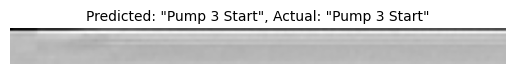

In [40]:
# Put the model in evaluation mode.
model.eval()

# Grab a test index
test_index = 105
x, y = MFCC_test_data[test_index][0], MFCC_test_data[test_index][1]

img  = x.squeeze()

with torch.no_grad():
    x = x.to(device)

    pred = model(x.unsqueeze(0)) # Create a batch size = 1 using unsqueeze()

    print("Outputs for all categories:")
    print(pred)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted: "{predicted}", Actual: "{actual}"', fontsize=10)
    plt.axis('off')
    plt.show()

<p>Finally, we can generate ROC curves and AUC scores for each of the One-vs-Rest cases</p>

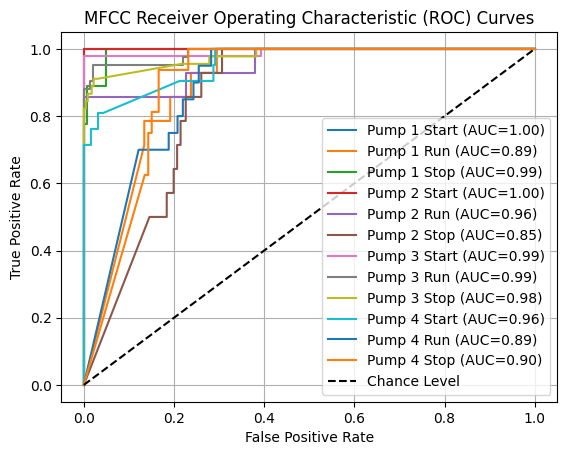

In [41]:
from torchmetrics.classification import ROC
from torchmetrics.classification import AUROC
import matplotlib.pyplot as plt

model.eval()
pred = 0;
for i in range(len(testInds)):
    # Grab a test index
    x, y_inst = MFCC_test_data[i]
    with torch.no_grad():
        x = x.to(device)
        if type(pred)==int:
            pred = model(x.unsqueeze(0))
            y = y_inst;
        else:
            pred = torch.cat((pred,model(x.unsqueeze(0))),dim=0);
            y = np.append(y, y_inst);
y = torch.as_tensor(y).to(device);

roc_metric = ROC(task="multiclass", num_classes=12)
roc_metric.update(pred, y)
fpr, tpr, thresholds = roc_metric.compute()

AUC = AUROC(task="multiclass", num_classes=12, average=None)
AUC.update(pred, y)
AUCs = AUC.compute()
#print(f"Aggregate ROC AUC: {AUCs[0].cpu().numpy():.4f}")


plt.figure()
for i in range(12):
    plt.plot(fpr[i].cpu(), tpr[i].cpu(), label=f"{classes[i]} (AUC={AUCs[i].cpu().numpy():.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level") # dashed diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MFCC Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.grid()
plt.show()

<p style="font-size:28px;font-weight:bold;">CNN Testing with LFCC Dataset</p>
Next, let's repeat the above process with our LFCC dataset. This dataset appears to struggle more than the MFCC dataset in training succesfully. If the test loss remains above 1, try running the training multiple times to see if you can get the results to perform better.

In [42]:
torch.cuda.empty_cache()
model2 = Test_CNN(n_filters1=4, n_filters2=8, num_of_cols=463).to(device)
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=1e-3)
train(LFCC_train_dataloader, model2, loss_fn2, optimizer2, 100);
acc, loss = test(LFCC_test_dataloader, model2, loss_fn2)
print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")

100%[--------------------]
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.291243 



In [43]:
torch.save(model2.state_dict(), "LFCC.pth")

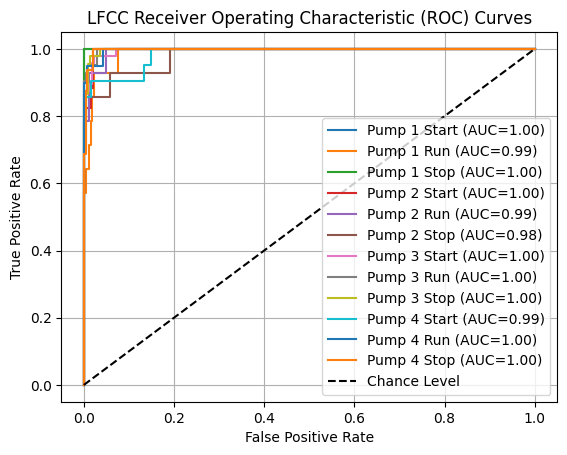

In [44]:
model2.eval()
pred = 0;
for i in range(len(testInds)):
    # Grab a test index
    x, y_inst = LFCC_test_data[i]
    with torch.no_grad():
        x = x.to(device)
        if type(pred)==int:
            pred = model2(x.unsqueeze(0))
            y = y_inst;
        else:
            pred = torch.cat((pred,model2(x.unsqueeze(0))),dim=0);
            y = np.append(y, y_inst);
y = torch.as_tensor(y).to(device);

roc_metric = ROC(task="multiclass", num_classes=12)
roc_metric.update(pred, y)
fpr, tpr, thresholds = roc_metric.compute()

AUC = AUROC(task="multiclass", num_classes=12, average=None)
AUC.update(pred, y)
AUCs = AUC.compute()
#print(f"Aggregate ROC AUC: {AUCs[0].cpu().numpy():.4f}")


plt.figure()
for i in range(12):
    plt.plot(fpr[i].cpu(), tpr[i].cpu(), label=f"{classes[i]} (AUC={AUCs[i].cpu().numpy():.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level") # dashed diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LFCC Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.grid()
plt.show()

<p style="font-size:20px;font-weight:bold;">Repeat Testing</p>
<p>Due to the unpredictability of the training success, we can run the training many times to see what the average performance is. The below code will train a separate model a given number of times and calculate the average accuracy across all sets.</p>
<p>The first thing we will do is build a function to calculate the ROC curve for each cycle, so we can find the statistically relevant range for the ROC. This function calculates the ROC curve as above, but uses interpolation to re-index it over a set of 200 points. This is done so that all of the ROC curves returned use the same False-Positive Rate indexing and can be averaged.</p>
<p>The next thing we do is run the training and test cycle over 10 "folds," or iterations. The Accuracy and Loss values are summed, and a list of the True Positive Rate curves are built. After we've finished the full cycle, the mean and standard deviations of the ROC curve are calculated and used to plot the true mean value along with a 95% confidence interval (1.96 × σ)</p>
<p>Please be aware, this can potentially take a <b>long</b> time</p>

In [45]:
from torchmetrics.classification import ROC
from torchmetrics.classification import AUROC
def calcROCAvg(mod, test_data, device):
    mod.eval()
    pred = 0;
    for i in range(len(testInds)):
        # Grab a test index
        x, y_inst = test_data[i]
        with torch.no_grad():
            x = x.to(device)
            if type(pred)==int:
                pred = mod(x.unsqueeze(0))
                y = y_inst;
            else:
                pred = torch.cat((pred,mod(x.unsqueeze(0))),dim=0);
                y = np.append(y, y_inst);
    y = torch.as_tensor(y).to(device);

    roc_metric = ROC(task="multiclass", num_classes=12, average="macro")
    roc_metric.update(pred, y)
    fpr, tpr, thresholds = roc_metric.compute()
    mean_fpr = np.linspace(0,1,200);
    tpr = np.interp(mean_fpr, fpr.cpu().numpy(), tpr.cpu().numpy());
    return mean_fpr, tpr, thresholds;

MFCC Loop 0
100%[--------------------]
MFCC Loop 1
100%[--------------------]
MFCC Loop 2
100%[--------------------]
MFCC Loop 3
100%[--------------------]
MFCC Loop 4
100%[--------------------]
MFCC Loop 5
100%[--------------------]
MFCC Loop 6
100%[--------------------]
MFCC Loop 7
100%[--------------------]
MFCC Loop 8
100%[--------------------]
MFCC Loop 9
100%[--------------------]
MFCC Average Test Error: 
 Accuracy: 27.7%, Avg loss: 1.936588 



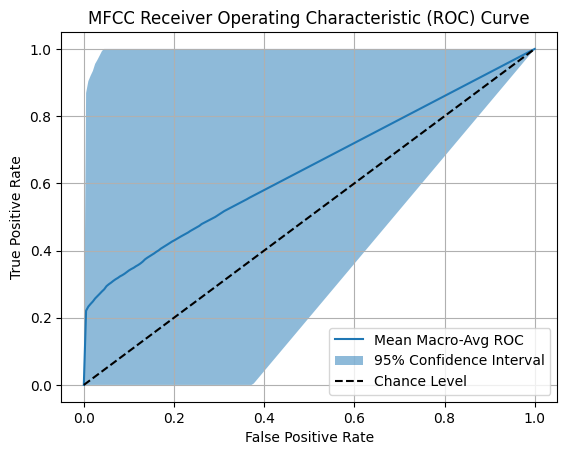

LFCC Loop 0
100%[--------------------]
LFCC Loop 1
100%[--------------------]
LFCC Loop 2
100%[--------------------]
LFCC Loop 3
100%[--------------------]
LFCC Loop 4
100%[--------------------]
LFCC Loop 5
100%[--------------------]
LFCC Loop 6
100%[--------------------]
LFCC Loop 7
100%[--------------------]
LFCC Loop 8
100%[--------------------]
LFCC Loop 9
100%[--------------------]
MFCC Average Test Error: 
 Accuracy: 51.6%, Avg loss: 1.318278 



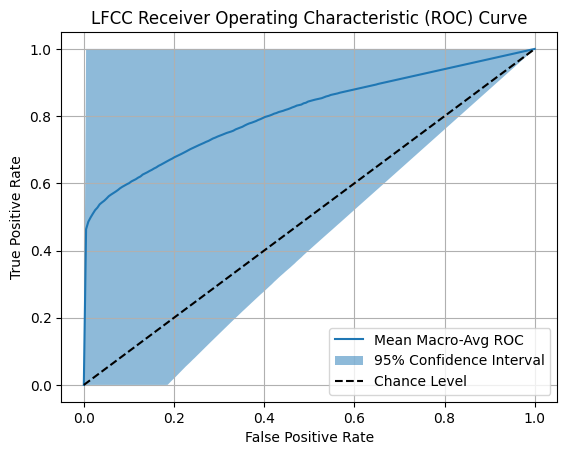

In [46]:
averages = 10;
MFCC_avg_acc = 0;
MFCC_avg_loss = 0;
LFCC_avg_acc = 0;
LFCC_avg_loss = 0;
tprs = [];

for i in range(averages):
    print(f"MFCC Loop {i}");
    torch.cuda.empty_cache()
    avg_model = Test_CNN(n_filters1=4, n_filters2=8).to(device)
    avg_loss_fn = nn.CrossEntropyLoss()
    avg_optimizer = torch.optim.SGD(avg_model.parameters(), lr=1e-3)
    train(MFCC_train_dataloader, avg_model, avg_loss_fn, avg_optimizer, 100);
    acc, loss = test(MFCC_test_dataloader, avg_model, avg_loss_fn)
    MFCC_avg_acc += acc;
    MFCC_avg_loss += loss;
    fpr, tpr, thres = calcROCAvg(avg_model, MFCC_test_data, device);
    tprs.append(tpr);
    tprs[-1][0] = 0.0;
mean_tpr = np.mean(tprs, axis=0);
mean_tpr[-1] = 1.0;
std_tpr = np.std(tprs, axis=0);
MFCC_avg_acc /= averages;
MFCC_avg_loss /= averages;
print(f"MFCC Average Test Error: \n Accuracy: {(100*MFCC_avg_acc):>0.1f}%, Avg loss: {MFCC_avg_loss:>8f} \n")
plt.figure();
plt.plot(fpr, mean_tpr, label="Mean Macro-Avg ROC");
plt.fill_between(fpr, np.maximum(mean_tpr - (1.96 * std_tpr), 0), np.minimum(mean_tpr + (1.96 * std_tpr),1), alpha=0.5, label="95% Confidence Interval");
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level") # dashed diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MFCC Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show();

tprs = [];
for i in range(averages):
    print(f"LFCC Loop {i}");
    torch.cuda.empty_cache()
    avg_model = Test_CNN(n_filters1=4, n_filters2=8, num_of_cols=463).to(device)
    avg_loss_fn = nn.CrossEntropyLoss()
    avg_optimizer = torch.optim.SGD(avg_model.parameters(), lr=1e-3)
    train(LFCC_train_dataloader, avg_model, avg_loss_fn, avg_optimizer, 100);
    acc, loss = test(LFCC_test_dataloader, avg_model, avg_loss_fn)
    LFCC_avg_acc += acc;
    LFCC_avg_loss += loss;
    fpr, tpr, thres = calcROCAvg(avg_model, LFCC_test_data, device);
    tprs.append(tpr);
    tprs[-1][0] = 0.0;
mean_tpr = np.mean(tprs, axis=0);
mean_tpr[-1] = 1.0;
std_tpr = np.std(tprs, axis=0);
LFCC_avg_acc /= averages;
LFCC_avg_loss /= averages;
print(f"MFCC Average Test Error: \n Accuracy: {(100*LFCC_avg_acc):>0.1f}%, Avg loss: {LFCC_avg_loss:>8f} \n")
plt.figure();
plt.plot(fpr, mean_tpr, label="Mean Macro-Avg ROC");
plt.fill_between(fpr, np.maximum(mean_tpr - (1.96 * std_tpr), 0), np.minimum(mean_tpr + (1.96 * std_tpr),1), alpha=0.5, label="95% Confidence Interval");
plt.plot([0, 1], [0, 1], 'k--', label="Chance Level") # dashed diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LFCC Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show();